<h1 align="center"> Recommendation Tools Individual Project </h1>
<h2 align="center"> Amazon Reviews </h1>
<h4 align="center"> Dilda Zhaksybek, March 2022 </h1>


The goal of this project is to develop recommendation systems for amazon reviews dataset using Surprise package.
This project demonstrated the application of 6 recommendation systems, as well as the preprocessing steps needed to apply the methods.

The evaluation of the project is judged upon the RMSE score calculated based on the submission to Kaggle competition at https://www.kaggle.com/c/recsys-2022/leaderboard

In [79]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from surprise import KNNBasic, SVD, CoClustering, Dataset, Reader, SVDpp
from surprise.model_selection import GridSearchCV
from IESEGRecSys import eval
from surprise import KNNBasic, SVD, CoClustering, Dataset, Reader, accuracy, BaselineOnly
import surprise 
from sklearn.model_selection import train_test_split

## Data Preprocessing


To begin, we import datasets. For this project, datasets are already partitioned into train and set.
Train set has a lenght of 161753 observations, test has a lenght of 76043 observations.

In [80]:
train = pd.read_csv("recsys-2022/train.csv").reset_index(drop=True)
test = pd.read_csv("recsys-2022/test_students.csv").reset_index(drop=True)

print(train.shape)
print(test.shape)


(161753, 8)
(76043, 3)


As we can see, the train set contains a dataframe with the following columns: 'userID', 'overall', 'asin', 'vote', 'reviewText', 'summary', 'style' and 'image'. To apply the collaborative filtering to generate recommendations, we will subset this dataframe later on. 

In [81]:
train.head(5)


,userID,overall,asin,vote,reviewText,summary,style,image
0,13527,5.0,B0002565TI,NaN,"These filters used to be sold at PetCo, but no...",Great Place to Get Filte-rs,NaN,NaN
1,14608,2.0,B0002H3ZLM,NaN,Did not work for my large- does. Returned it.,T#wo Stars,"{'Size:': ' LARGE 60-130 LBS.', 'Color:': ' BL...",NaN
2,15536,5.0,B0009YD8OC,NaN,I was pretty skeptical that this would be easy...,stops pulling in a 6 month 60{ pound pup great!,NaN,NaN
3,12868,5.0,B001VPA9OK,NaN,Works great for groom-ing my dog. A must have.,Five /Stars,{'Color:': ' Silver'},NaN
4,181,5.0,B000K67UF2,NaN,Great cage for budgies! I cant say enough marv...,Great cage for budg{ies,"{'Size:': ' Medium', 'Pattern:': ' MO2 Cage'}",NaN


Test set only contains ID, which is a concatenated string of UserID and asin. 

In [82]:
test.head(5)

,ID,userID,asin
0,21069B00BFK2B24,21069,B00BFK2B24
1,3506B00ZK0Y7R2,3506,B00ZK0Y7R2
2,21907B0002AQPA2,21907,B0002AQPA2
3,14092B0002DHXX2,14092,B0002DHXX2
4,3085B0006VB3SQ,3085,B0006VB3SQ


A subset of the trainset to only include UserID, asin (itemID) and rating to create a user-item rating matrix that can later be fed to the surprise package.

In [83]:
train = train[['userID','asin','overall']]
train.head()

,userID,asin,overall
0,13527,B0002565TI,5.0
1,14608,B0002H3ZLM,2.0
2,15536,B0009YD8OC,5.0
3,12868,B001VPA9OK,5.0
4,181,B000K67UF2,5.0


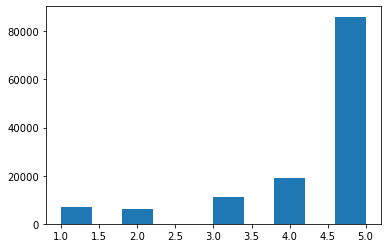

In [101]:
plt.hist(train['overall'])
plt.show()

For the test set, ID column is removed and an empty ratings columns is created, for which the prediction will be made later on. 

In [84]:
test = test[['userID', 'asin']]
test['overall'] = 0
test.head()

,userID,asin,overall
0,21069,B00BFK2B24,0
1,3506,B00ZK0Y7R2,0
2,21907,B0002AQPA2,0
3,14092,B0002DHXX2,0
4,3085,B0006VB3SQ,0


## Train-validation split

Datasets are given as train and test already. However, test set will be used to make a final prediction and submit to the kaggle competition. As an intermediary step, validation test is needed to compute the evaluation metrics. 

Using train_test_split function of sklearn package, validation test set is set to be 20% of the train.

In [85]:
# train-test split
train, validation = train_test_split(train, test_size=0.2, random_state=42)

# reset index
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)


## Defining Surprise datasets

To apply recommendation algorithms of the surprise package, we need to create surprise datasets. We define a variable "reader" to define a rating scale given by the users, which from 1 (lowest) to 5 (highest).

We then load pandas dataframe to surprise dataframe via *surprise.Dataset.load_from_df*.
For the test set, we use the *intertuples* function to create an object of tuples for each row of the test data frame.

In [86]:
reader = surprise.Reader(rating_scale=(1, 5))

data = surprise.Dataset.load_from_df(train, reader) #for the grid search
df_train = surprise.Dataset.load_from_df(train, reader).build_full_trainset()
df_validation = list(validation.itertuples(index=False, name=None))
df_test = list(test.itertuples(index=False, name=None))

## Defining the algorythms 


We define 6 prediction algorythms for application:

* User-based KNN
* Item-based KNN
* Baseline 
* SVD
* SVD ++
* CoClustering

#### KNN
KNNbasic is derived from the k-nearest neighbors approach. It is a collaborative filtering algorithm, meaning recommendations will be made based on the similarities in preferences of other users.

An estimation is computed based on the aggregation of the nearest K (equal or less than) neighbors. Only positively correlated neighbors considered for the estimation.

User-based set to **True** will compute similarities between users, whereas **False** will compute similarities between items.
For both user-based and item based KNNbasic, a minimum of 5 and a maximum of 15 neighbors was selected. 
To compute the similarity **cosine** measure is selected in the name option. Also known as vector-based similarity, similarity is computed as sum of products between two vectors divided by the product of their length.

In [96]:
# user-based
options = {'name':'cosine', 'user_based':True}
ub = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)

# item-based
options = {'name':'cosine', 'user_based':False}
ib = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)

#### Baseline

Baseline algorithms tries to minimize regularized square error of the observation. It estimates the baseline for the given user and item using Alternating Least Squares approach. **n_epoch**, the number of iterations of the ALS procedure is set to 30. 

In [98]:
# =alternating least squares (ALS) and 30 epochs
options = {"method": "als", "n_epochs": 30}
als = BaselineOnly(bsl_options=options)

#### SVD and SVDpp

SVD, or single value decomposition algorithm, is a matrix factorization technique. SVD decomposes user-item matrix into left and right singular and diagnonal matrices. It then factorized the decomposed matrices to reduce dimensionality. Hence, it simplifies data, removes noise and improves the result given by the algorithm.

SVDpp is the extension of the SVD, and is considered to produce a better prediction results than SVD. SVD++ takes into account implicit ratings, meaning it takes into account the fact that specific user rated a specific item, regardless of the rating score given. 

We apply both with **n_factors** of 50 factors, and **random_state** of 42 (making results reproducible). With one difference, **biased = True** for the SVD, using the biased version of the algorithm, instead of its probabilistic (unbiased) version.

In [87]:
# svd
mf = SVD(n_factors=50, biased=True, random_state=42)

# svd ++
svd_pp = SVDpp(n_factors=100,  random_state=42)



#### Co-Clustering

In this collaborative-filtering algorithm, users and items each assigned to the pre-defined number of clusters, and some co-clusters, based on their similarity.

The number of user clusters **n_cltr_u** is set to 10, number of items clusters, **n_cltr_i**, is set to 10. Number of iterations **n_epoch** is set to 50.

In [ ]:

# clustering
clust = CoClustering(n_cltr_u=10, n_cltr_i=10, n_epochs=50, random_state=42)

## Applying and evaluating algorithms

The above defined models are fit on the train data set, and evaluation results are computed by fitting on the validation set. 
Of the 6 defined models, SVD yields the best results with RMSE of 1.071 and MAE of 0.789, as well as the higher precision of 0.861.
However, the recall, or the ratio of correct identification of the true-positive to all actual true positives is 0.851, which is inferior to those given by KNN and Baseline models, dragging the F1, model accuracy on the dataset, down.


In [95]:
models = {"UB_KNN":ub, "IB_KNN":ib, "ALS":als, "SVD":mf, "SVD_PP":svd_pp, "CoClust":clust}
overview = pd.concat([eval.evaluate(mod.fit(df_train).test(df_validation), topn=5, rating_cutoff=4) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


<ipython-input-95-7bd4a677d2f9>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  overview = pd.concat([eval.evaluate(mod.fit(df_train).test(df_validation), topn=5, rating_cutoff=4) for mod in models.values()], axis=1)


,UB_KNN,IB_KNN,ALS,SVD,SVD_PP,CoClust
RMSE,1.149506,1.135639,1.078814,1.071176,1.078126,1.267936
MAE,0.868751,0.865290,0.813771,0.793804,0.789118,0.837199
Recall,0.925091,0.947134,0.892597,0.851893,0.841289,0.770903
Precision,0.821526,0.823644,0.849526,0.861188,0.860018,0.860476
F1,0.870238,0.881083,0.870529,0.856515,0.850550,0.813230
NDCG@5,0.917273,0.930818,0.910222,0.910896,0.907974,0.916753


### Hyperparameter tuning and cross-validation

As SVD gives the best result on the validation set according to the RMSE, this is the model a search for the best hyperparameters will be made for. To do so, a dictionary **param_grid** is defined, that hold all the potential variables for the SVD model tuning. *GridSearchCV* gives the set of parameters that minimizes the mean score across **cv=3** k-fold cross validated dataset.

A search on best hyperparameters is made on:
* n_factors - number of factors
* n_epoch - number of iterations
* lr_all - learning rate of parameters
* reg_all - regularization term of parameters.

In [68]:
param_grid = {'n_factors':[ 50, 150, 200],
             'n_epochs':[20,40, 60],
              'biased' : [True],
             'lr_all':[ 0.02 ,0.03, 0.04],
             'reg_all':[0.02,0.04,0.05]}

gs = GridSearchCV(SVD,
                            param_grid=param_grid,
                            measures=['rmse'],
                            cv=3)
gs.fit(data)

In [92]:
print(f"Best params with respect to RMSE: ",gs.best_params['rmse'])
print(f"RMSE achieved:", gs.best_score)

Best params with respect to RMSE:  {'n_factors': 200, 'n_epochs': 60, 'biased': True, 'lr_all': 0.04, 'reg_all': 0.04}
RMSE achieved: {'rmse': 1.0676338947587207}


## Application of the final model

The above are the results of the *last* run of the grid search. RMSE achieved with those parameters is 1.067. Those parameters, stored in *params* variable, are used to define the model and predict the test dataset values.

In [99]:
#fitting SVD with the best params according to RMSE

params = gs.best_params['rmse']

final_model = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

#fit on training set
final_model.fit(df_train)
pred_df = final_model.test(df_test)


Lastly, we make a pandas dataframe of the resulting test prediction. We finalize by combining id and asin variables into a single ID variable. The resulting dataframe for Kaggle competition submission contains ID and Overall estimated result for each observation. 

In [71]:
pred_df = pd.DataFrame(pred_df)
pred_df = pred_df[["uid","iid","est"]]
pred_df["ID"] = pred_df["uid"].astype("str") + pred_df["iid"].astype("str")
pred_df = pred_df.rename(columns={"est":"overall"})
pred_df = pred_df[['ID','overall']]

pred_df.head()

,ID,overall
0,21069B00BFK2B24,2.870341
1,3506B00ZK0Y7R2,3.186308
2,21907B0002AQPA2,3.460876
3,14092B0002DHXX2,4.501385
4,3085B0006VB3SQ,4.714695


In [72]:
pred_df.to_csv("results/results.csv",index=False)

## Conclusion

Using the hyperparameter tuned, cross-validated SVD model, the best achieved submission was an RMSE of 0.96807.

### References

* https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657
* https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
* https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html
* https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919
